# One step univariate model

Download zipfile from https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0 and store in the data folder.

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a simple RNN model in keras to predict the next step ahead (time *t+1*) in the time series
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load data only.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
%matplotlib inline

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

In [4]:
!wget https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip

--2018-06-27 14:14:26--  https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uca81a6f8a1c0584670745f9f47e.dl.dropboxusercontent.com/cd/0/get/AJ4rUsx0N8JMj2-TahyyaIJpCdKZ7dwbCGLjBXd0YbUD2xg9_NQhYFG6IvC8aTSIVMxoeeSQkRXj41fydR9EdldDH2y3H5bK-oTLCPPnSD6i8d-uXiAenKqLFMSD06ph78QVQv7ECoYez0XwbQbJIoIxstVEmEw7-3dOeLaktz9yodHq8D07f9CUNm64h7oL56k/file [following]
--2018-06-27 14:14:26--  https://uca81a6f8a1c0584670745f9f47e.dl.dropboxusercontent.com/cd/0/get/AJ4rUsx0N8JMj2-TahyyaIJpCdKZ7dwbCGLjBXd0YbUD2xg9_NQhYFG6IvC8aTSIVMxoeeSQkRXj41fydR9EdldDH2y3H5bK-oTLCPPnSD6i8d-uXiAenKqLFMSD06ph78QVQv7ECoYez0XwbQbJIoIxstVEmEw7-3dOeLaktz9yodHq8D07f9CUNm64h7oL56k/file
Resolving uca81a6f8a1c0584670745f9f47e.dl.dropboxusercontent.com (uca81a6f8a1c0584670745f9f47e.dl.dropboxuserc

In [5]:
!mv GEFCom2014.zip ./data

If not done already, extract zipped data and save as csv

In [6]:
if not os.path.exists(os.path.join('data', 'energy.csv')):
    %run common/extract_data.py

Load the data from csv into a Pandas dataframe

In [7]:
# %load common/load_data.py
def load_data():

    # read GEFCom2014 load data

    data_dir = 'data/'

    energy = pd.read_csv(os.path.join(data_dir, 'energy.csv'), parse_dates=['timestamp'])

    # Reindex the dataframe such that the dataframe has a record for every time point
    # between the minimum and maximum timestamp in the time series. This helps to 
    # identify missing time periods in the data (there are none in this dataset).

    energy.index = energy['timestamp']
    energy = energy.reindex(pd.date_range(min(energy['timestamp']),
                                          max(energy['timestamp']),
                                          freq='H'))
    energy = energy.drop('timestamp', axis=1)

    return energy

In [8]:
energy = load_data()[['load']]
energy.head()

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


Plot all available load data (January 2012 to Dec 2014)

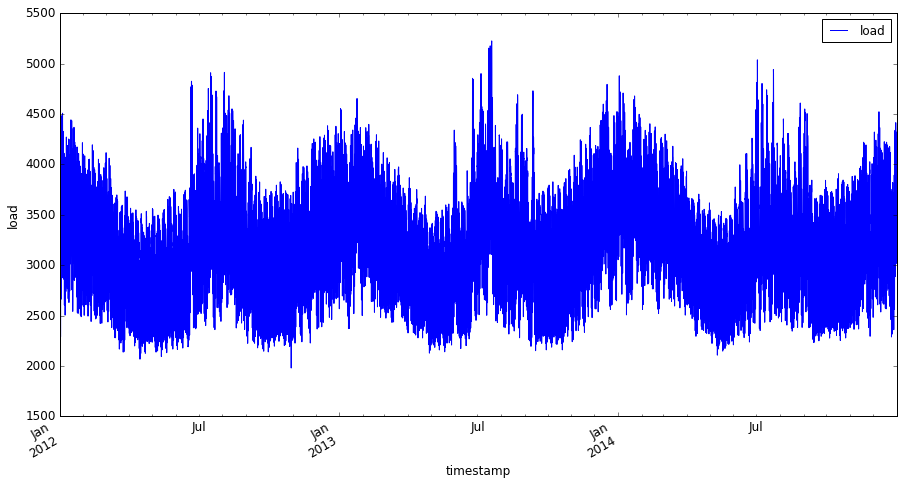

In [9]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

Plot first week of July 2014

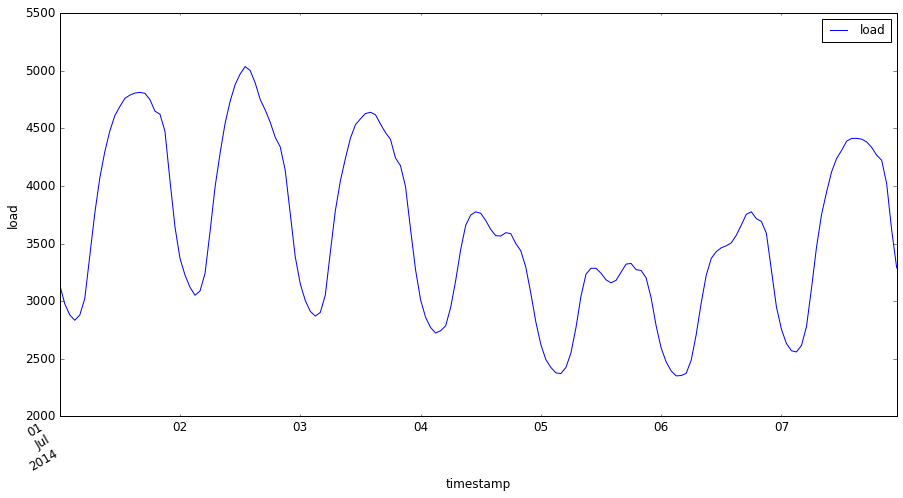

In [10]:
energy['2014-07-01':'2014-07-07'].plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## Create train, validation and test sets

We separate our dataset into train, validation and test sets. We train the model on the train set. The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data. After the model has finished training, we evaluate the model on the test set. We must ensure that the validation set and test set cover a later period in time from the training set, to ensure that the model does not gain from information from future time periods.

We will allocate the period 1st November 2014 to 31st December 2014 to the test set. The period 1st September 2014 to 31st October is allocated to validation set. All other time periods are available for the training set.

In [11]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

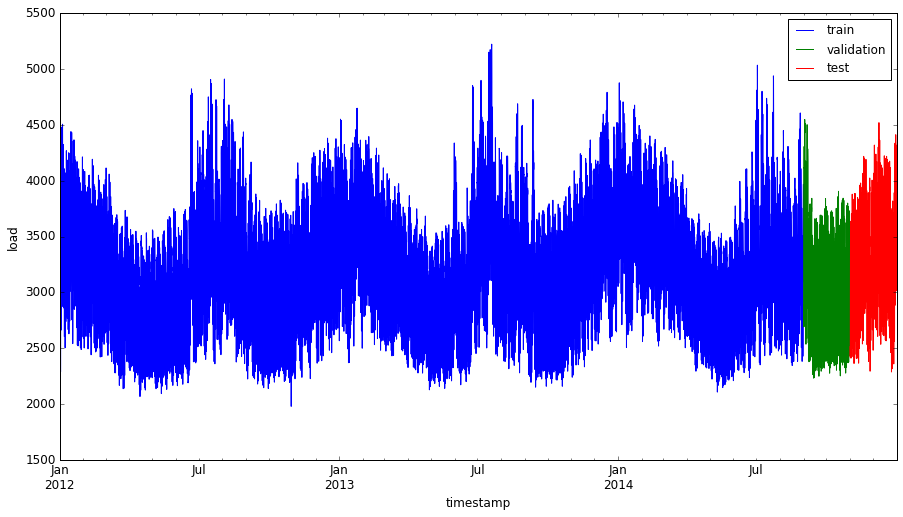

In [12]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'train'}) \
    .join(energy[(energy.index >=valid_start_dt) & (energy.index < test_start_dt)][['load']] \
          .rename(columns={'load':'validation'}), how='outer') \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## Data preparation

For this example, we will set *T=6*. This means that the input for each sample is a vector of the prevous 6 hours of the energy load. The choice of *T=6* was arbitrary but should be selected through experimentation.

*HORIZON=1* specifies that we have a forecasting horizon of 1 (*t+1*)

In [18]:
T = 6
HORIZON = 1

Our data preparation for the training set will involve the following steps:

1. Filter the original dataset to include only that time period reserved for the training set
2. Scale the time series such that the values fall within the interval (0, 1)
3. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
4. Discard any samples with missing values
5. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

Create training set containing only the model features

In [23]:
train = energy.copy()[energy.index < valid_start_dt][['load']]

Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
2012-01-01 00:00:00,0.22
2012-01-01 01:00:00,0.18
2012-01-01 02:00:00,0.14
2012-01-01 03:00:00,0.13
2012-01-01 04:00:00,0.13
2012-01-01 05:00:00,0.15
2012-01-01 06:00:00,0.18
2012-01-01 07:00:00,0.23
2012-01-01 08:00:00,0.29
2012-01-01 09:00:00,0.35


Original vs scaled data:

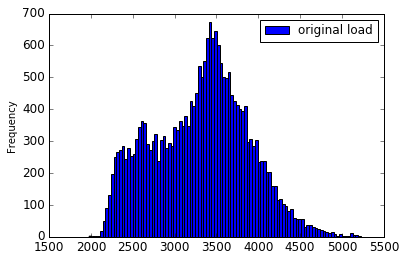

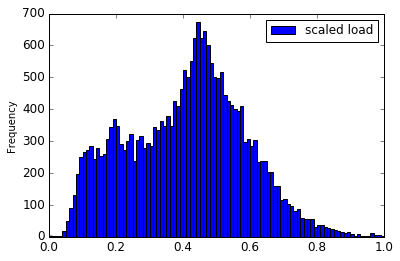

In [25]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

Now we shift the dataframe to create the input samples.

First, we create the target (*y_t+1*) variable. If we use the convention that the dataframe is indexed on time *t*, we need to shift the *load* variable forward one hour in time. Using the freq parameter we can tell Pandas that the frequency of the time series is hourly. This ensures the shift does not jump over any missing periods in the time series.

In [26]:
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')
train_shifted.head(10)

,load,y_t+1
2012-01-01 00:00:00,0.22,0.18
2012-01-01 01:00:00,0.18,0.14
2012-01-01 02:00:00,0.14,0.13
2012-01-01 03:00:00,0.13,0.13
2012-01-01 04:00:00,0.13,0.15
2012-01-01 05:00:00,0.15,0.18
2012-01-01 06:00:00,0.18,0.23
2012-01-01 07:00:00,0.23,0.29
2012-01-01 08:00:00,0.29,0.35
2012-01-01 09:00:00,0.35,0.37


We also need to shift the load variable back 6 times to create the input sequence:

In [27]:
for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted['load'].shift(T-t, freq='H')

In [30]:
y_col = 'y_t+1'
X_cols = ['load_t-5',
             'load_t-4',
             'load_t-3',
             'load_t-2',
             'load_t-1',
             'load_t']
train_shifted.columns = ['load_original']+[y_col]+X_cols
train_shifted.head(10)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35
2012-01-01 10:00:00,0.37,0.37,0.15,0.18,0.23,0.29,0.35,0.37
2012-01-01 11:00:00,0.37,0.37,0.18,0.23,0.29,0.35,0.37,0.37
2012-01-01 12:00:00,0.37,0.36,0.23,0.29,0.35,0.37,0.37,0.37
2012-01-01 13:00:00,0.36,0.35,0.29,0.35,0.37,0.37,0.37,0.36
2012-01-01 14:00:00,0.35,0.36,0.35,0.37,0.37,0.37,0.36,0.35


Notice how we have missing values for the input sequences for the first 5 samples. We will discard these:

In [31]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35


Now convert the target and input features into numpy arrays. X needs to be in the shape (samples, time steps, features). Here we have 23370 samples, 6 time steps and 1 feature (load).

In [32]:
y_train = train_shifted[[y_col]].as_matrix()

X_train = train_shifted[X_cols].as_matrix()
X_train = X_train.reshape(X_train.shape[0], T, 1)

We now have a vector for target variable of shape:

In [33]:
y_train.shape

(23370, 1)

The target varaible for the first 3 samples looks like:

In [34]:
y_train[:3]

array([[0.18],
       [0.23],
       [0.29]])

The tensor for the input features now has the shape:

In [35]:
X_train.shape

(23370, 6, 1)

And the first 3 samples looks like:

In [36]:
X_train[:3]

array([[[0.22],
        [0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15]],

       [[0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18]],

       [[0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23]]])

We can sense check this against the first 3 records of the original dataframe:

In [37]:
train_shifted.head(3)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23


Now we follow a similar process for the validation set. We keep *T* hours from the training set in order to construct initial features.

In [38]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]
valid.head()

,load
2014-08-31 19:00:00,"3,969.00"
2014-08-31 20:00:00,"3,869.00"
2014-08-31 21:00:00,"3,643.00"
2014-08-31 22:00:00,"3,365.00"
2014-08-31 23:00:00,"3,097.00"


Scale the series using the transformer fitted on the training set:

In [39]:
valid['load'] = scaler.transform(valid)
valid.head()

,load
2014-08-31 19:00:00,0.61
2014-08-31 20:00:00,0.58
2014-08-31 21:00:00,0.51
2014-08-31 22:00:00,0.43
2014-08-31 23:00:00,0.34


Prepare validation inputs in the same way as the training set:

In [40]:
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    valid_shifted['load_t-'+str(T-t)] = valid_shifted['load'].shift(T-t, freq='H')
valid_shifted = valid_shifted.dropna(how='any')
y_valid = valid_shifted['y+1'].as_matrix()
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].as_matrix()
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

In [41]:
y_valid.shape

(1463,)

In [42]:
X_valid.shape

(1463, 6, 1)

## Implement the RNN

We will implement a simple RNN forecasting model with the following structure:

![One step univariate RNN model](./images/one_step_univariate.png "One step univariate RNN model")

In [43]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [45]:
LATENT_DIM = 5 # number of units in the RNN layer
BATCH_SIZE = 32 # number of samples per mini-batch
EPOCHS = 50 # maximum number of times the training algorithm will cycle through all samples

In [46]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

Use mean squared error as the loss function. The Keras documentation recommends the optimizer RMSprop for RNNs.

In [47]:
model.compile(optimizer='RMSprop', loss='mse')

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 105       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


Specify the early stopping criteria. We **monitor** the validation loss (in this case the mean squared error) on the validation set after each training epoch. If the validation loss has not improved by **min_delta** after **patience** epochs, we stop the training.

In [49]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [50]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

Train on 23370 samples, validate on 1463 samples
Epoch 1/50
23370/23370 [==============================] - 4s 171us/step - loss: 0.0136 - val_loss: 0.0015
Epoch 2/50
23370/23370 [==============================] - 4s 154us/step - loss: 0.0011 - val_loss: 7.2698e-04
Epoch 3/50
23370/23370 [==============================] - 4s 171us/step - loss: 7.6860e-04 - val_loss: 6.2823e-04
Epoch 4/50
23370/23370 [==============================] - 4s 153us/step - loss: 6.5542e-04 - val_loss: 6.5476e-04
Epoch 5/50
23370/23370 [==============================] - 4s 166us/step - loss: 6.0219e-04 - val_loss: 5.5284e-04
Epoch 6/50
23370/23370 [==============================] - 4s 153us/step - loss: 5.7482e-04 - val_loss: 5.1993e-04
Epoch 7/50
23370/23370 [==============================] - 4s 167us/step - loss: 5.6399e-04 - val_loss: 5.5819e-04
Epoch 8/50
23370/23370 [==============================] - 4s 166us/step - loss: 5.6007e-04 - val_loss: 5.2922e-04
Epoch 9/50
23370/23370 [===========================

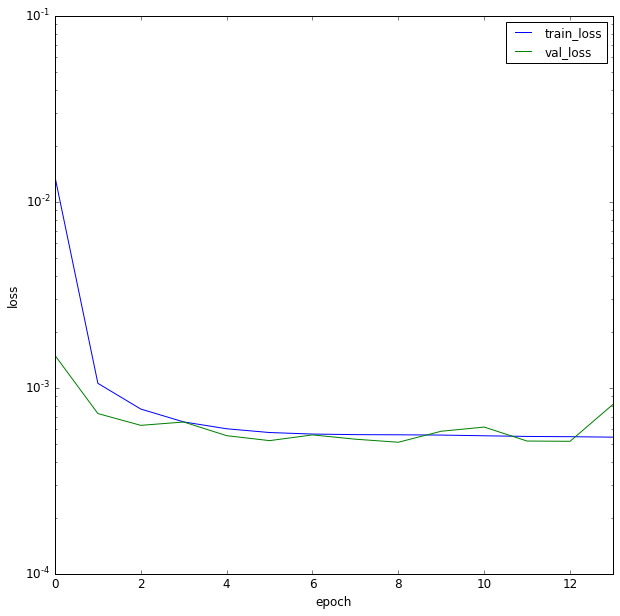

In [51]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

## Evaluate the model

Create the test set

In [52]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load']]
test.head()

,load
2014-11-01 00:00:00,"2,514.00"
2014-11-01 01:00:00,"2,434.00"
2014-11-01 02:00:00,"2,390.00"
2014-11-01 03:00:00,"2,382.00"
2014-11-01 04:00:00,"2,419.00"


Scale the test data

In [53]:
test['load'] = scaler.transform(test)
test.head()

,load
2014-11-01 00:00:00,0.16
2014-11-01 01:00:00,0.14
2014-11-01 02:00:00,0.13
2014-11-01 03:00:00,0.12
2014-11-01 04:00:00,0.14


Create test set input tensors

In [54]:
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    test_shifted['load_t-'+str(T-t)] = test_shifted['load'].shift(T-t, freq='H')
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted['y_t+1'].as_matrix()
X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].as_matrix()
X_test = X_test.reshape(X_test.shape[0], T, 1)

Make predictions on test set

In [55]:
predictions = model.predict(X_test)
predictions

array([[0.23],
       [0.31],
       [0.39],
       ...,
       [0.55],
       [0.48],
       [0.44]], dtype=float32)

Compare predictions to actual load

In [56]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,713.80","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,982.98","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,248.90","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,388.73","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,522.33","3,436.00"


Compute the mean absolute percentage error over all predictions

In [57]:
# %load common/mape.py
def mape(predictions, actuals):
    return ((predictions - actuals).abs() / actuals).mean()

In [58]:
mape(eval_df['prediction'], eval_df['actual'])

0.022005166037335152

Plot the predictions vs the actuals for the first week of the test set

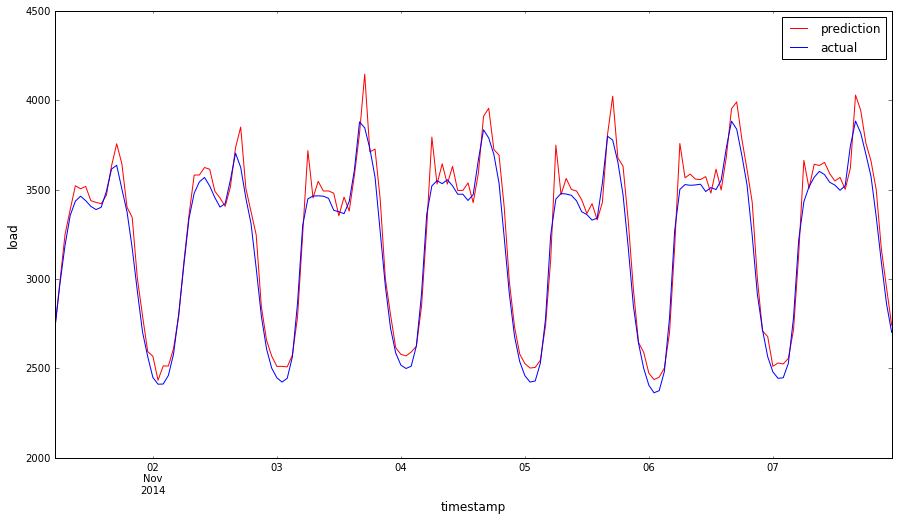

In [59]:
eval_df[eval_df.timestamp<'2014-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()